In [ ]:
# Instalacion de librerias

In [4]:
# Librerías a utilizar
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
# Base URL del sitio web
base_url = "https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_{}.html"

# Lista para almacenar los datos de todas las páginas
all_data = []

# Iterar por las páginas de datos (1 a 10)
for i in range(1, 11):
    url = base_url.format(i)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Encontrar la tabla
    table = soup.find('table')
    if table:
        # Extraer encabezados
        headers = [th.text.strip() for th in table.find_all('th')]

        # Extraer filas
        rows = []
        for row in table.find_all('tr')[1:]:
            cells = [cell.text.strip() for cell in row.find_all('td')]
            if cells:  # Solo agregar filas no vacías
                rows.append(cells)

        # Crear DataFrame de la tabla actual
        df = pd.DataFrame(rows, columns=headers)
        all_data.append(df)

# Concatenar todos los DataFrames en uno solo
final_data = pd.concat(all_data, ignore_index=True)

# Guardar el resultado en un archivo CSV
final_data.to_csv("geih_2018_bogota.csv", index=False)

Datos combinados guardados en 'geih_2018_bogota.csv'.


In [10]:
final_data

,,directorio,secuencia_p,orden,clase,dominio,mes,estrato1,sex,age,...,y_viaticos_m,y_accidentes_m,y_salarySec_m,y_ingLab_m_ha,y_gananciaNeta_m,y_gananciaNetaAgro_m,y_gananciaIndep_m,y_gananciaIndep_m_hu,y_total_m,y_total_m_ha
0,1,4514331,1,2,1,BOGOTA,1,2,0,29,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,2,4514331,1,1,1,BOGOTA,1,2,1,36,...,NA,NA,NA,8404.3203125,NA,NA,NA,NA,1620833.25,8404.3203125
2,3,4514332,1,4,1,BOGOTA,1,2,1,4,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,4,4514332,1,3,1,BOGOTA,1,2,1,7,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,5,4514332,1,1,1,BOGOTA,1,2,0,32,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32172,3213,4804454,1,2,1,BOGOTA,12,2,0,24,...,NA,NA,NA,3345.5556640625,NA,NA,NA,NA,1003666.6875,3345.5556640625
32173,3214,4804455,1,1,1,BOGOTA,12,3,0,36,...,5e+05,NA,NA,25958.333984375,NA,NA,NA,NA,6675000,25958.333984375
32174,3215,4804455,1,2,1,BOGOTA,12,3,1,41,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
32175,3216,4804455,1,3,1,BOGOTA,12,3,1,8,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [26]:
# Filtrar personas mayores de 18 años y empleadas
filtered_data = final_data[
    (final_data['age'].astype(float) > 18) &
    (final_data['ocu'].astype(float) == 1)
]

# Reemplazar valores no numéricos por NaN
filtered_data['y_salary_m'] = pd.to_numeric(filtered_data['y_salary_m'], errors='coerce')

# Filtrar por asalariados y eliminar valores no nulos
filtered_data = filtered_data[
    (filtered_data['y_salary_m'] > 0) &
    (filtered_data['y_salary_m'].notnull())
]

# Calcular salario por hora
filtered_data['hourly_wage'] = (
    filtered_data['y_salary_m'].astype(float) /
    filtered_data['hoursWorkUsual'].astype(float)
)

# Manejar valores faltantes
filtered_data = filtered_data.dropna(subset=['hourly_wage', 'age', 'sex', 'maxEducLevel'])

# Resumen de los datos procesados
filtered_data

<ipython-input-26-821d39e9a626>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['y_salary_m'] = pd.to_numeric(filtered_data['y_salary_m'], errors='coerce')


,,directorio,secuencia_p,orden,clase,dominio,mes,estrato1,sex,age,...,y_accidentes_m,y_salarySec_m,y_ingLab_m_ha,y_gananciaNeta_m,y_gananciaNetaAgro_m,y_gananciaIndep_m,y_gananciaIndep_m_hu,y_total_m,y_total_m_ha,hourly_wage
1,2,4514331,1,1,1,BOGOTA,1,2,1,36,...,NA,NA,8404.3203125,NA,NA,NA,NA,1620833.25,8404.3203125,28888.888889
8,9,4514333,1,1,1,BOGOTA,1,2,1,51,...,NA,NA,6703.3427734375,NA,NA,NA,NA,1378973.375,6703.3427734375,25000.000000
13,14,4514334,1,1,1,BOGOTA,1,2,1,45,...,NA,NA,3680.65405273438,NA,NA,NA,NA,883357,3680.65405273438,13173.517857
15,16,4514335,1,1,1,BOGOTA,1,2,1,61,...,NA,NA,4083.33325195312,NA,NA,NA,NA,7e+05,4083.33325195312,17500.000000
21,22,4514338,1,2,1,BOGOTA,1,2,0,35,...,NA,NA,9437.84765625,NA,NA,NA,NA,1941500.125,9437.84765625,35416.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32164,3205,4804453,1,6,1,BOGOTA,12,3,1,24,...,NA,NA,5288.888671875,NA,NA,NA,NA,1088000,5288.888671875,21625.000000
32166,3207,4804453,1,8,1,BOGOTA,12,3,0,50,...,NA,NA,4864.12744140625,NA,NA,NA,NA,1146544.375,4864.12744140625,18472.727273
32171,3212,4804454,1,1,1,BOGOTA,12,2,1,27,...,NA,NA,4453.359375,NA,NA,NA,NA,916119.6875,4453.359375,16275.875000
32172,3213,4804454,1,2,1,BOGOTA,12,2,0,24,...,NA,NA,3345.5556640625,NA,NA,NA,NA,1003666.6875,3345.5556640625,12857.142857


In [27]:
# Estadísticas descriptivas generales
descriptive_stats = filtered_data[['age', 'hoursWorkUsual', 'y_salary_m', 'hourly_wage']].describe()
print(descriptive_stats)

         y_salary_m   hourly_wage
count  9.785000e+03  9.785000e+03
mean   1.566234e+06  3.421827e+04
std    2.158107e+06  4.984040e+04
min    1.000000e+04  6.510417e+02
25%    7.812420e+05  1.627588e+04
50%    9.000000e+05  1.937500e+04
75%    1.500000e+06  3.125000e+04
max    3.400000e+07  1.250000e+06


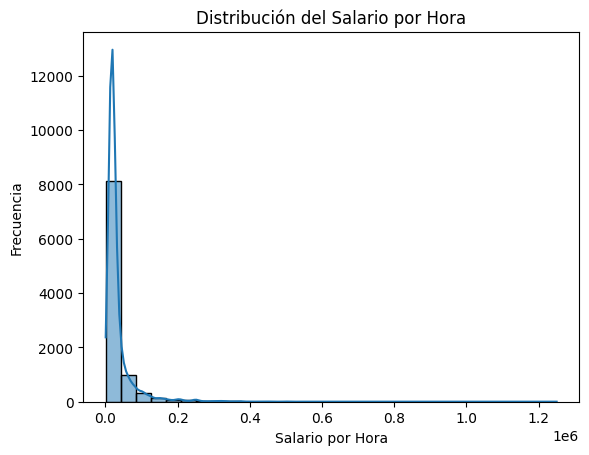

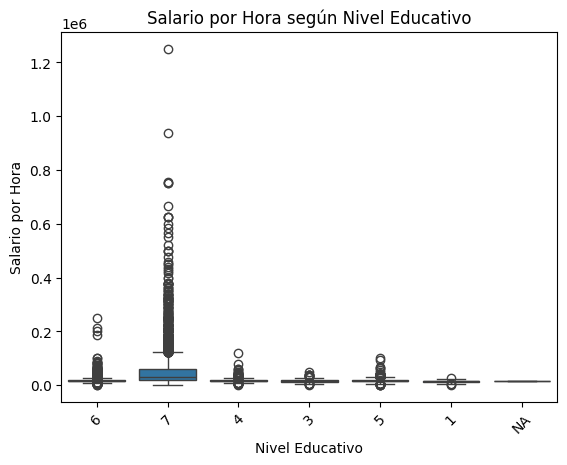

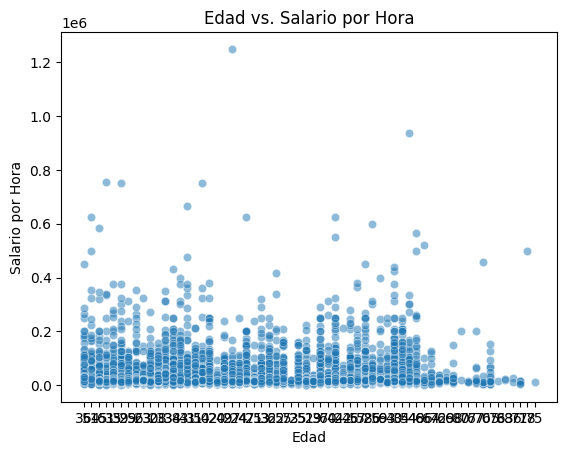

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograma de salarios por hora
sns.histplot(filtered_data['hourly_wage'], kde=True, bins=30)
plt.title('Distribución del Salario por Hora')
plt.xlabel('Salario por Hora')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de salarios por nivel educativo
sns.boxplot(x='maxEducLevel', y='hourly_wage', data=filtered_data)
plt.title('Salario por Hora según Nivel Educativo')
plt.xlabel('Nivel Educativo')
plt.ylabel('Salario por Hora')
plt.xticks(rotation=45)
plt.show()

# Scatterplot de edad vs salario por hora
sns.scatterplot(x='age', y='hourly_wage', data=filtered_data, alpha=0.5)
plt.title('Edad vs. Salario por Hora')
plt.xlabel('Edad')
plt.ylabel('Salario por Hora')
plt.show()
